<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/3minuteGAN(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b>경쟁하며 학습하는 GAN</b>

### GAN의 3가지 특징
 - 생성하는 모델. 즉, 새로운 이미지나 음성을 창작
 - 적대적으로 학습. 가짜 이미지를 생성하는 생성자와 이미지의 진위를 판별하는 판별자가 번갈아가며 경쟁적으로 학습.
 - 인공 신경망 모델

### GAN은 생성자와 판별자 2가지 모듈로 구성된다. 생성자는 학습이 진행되면서 판별자를 속이기 위해 점점 더 정밀한 가짜 이미지 생성하고, 판별자는 학습이 진행되면서 그 가짜 이미지를 점점 더 잘 구별하게 된다. 

In [0]:
# 중요 라이브러리 임포트

import torch
import os
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torchvision.utils import save_image
import numpy as np

In [0]:
# 하이퍼파라미터 설정

EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('다음 장치를 사용합니다.', DEVICE)

다음 장치를 사용합니다. cuda


In [0]:
# 학습에 필요한 데이터 불러오기(텐서변환, 정규화 적용)

trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True)

In [0]:
# 이전에 nn.Module 클래스를 정의한 것과 다르게 간단히 모델을 구현하기 위해 Sequential 클래스 사용
# Sequential 클래스는 각 층에서의 연산들을 입력받아 순차적으로 실행(__init__과 forward 함수를 동시에 적용)

G = nn.Sequential(nn.Linear(64,256), nn.ReLU(), nn.Linear(256,256), nn.ReLU(), nn.Linear(256,784), nn.Tanh())

In [0]:
# Leaky ReLU 함수는 판별자에서 계산된 기울기가 약한 음수로 전환되어 생성자에게 더 강하게 전달되도록 하는 역할

D = nn.Sequential(nn.Linear(784,256), nn.LeakyReLU(0.2), nn.Linear(256,256), nn.LeakyReLU(0.2), nn.Linear(256,1), nn.Sigmoid())

In [0]:
D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [0]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
  for i, (images, _) in enumerate(train_loader):
    images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
    # 진짜와 가짜 레이블 생성
    real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
    outputs = D(images)
    # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    # 무작위 텐서로 가짜 이미지 생성
    z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
    fake_images = G(z)
    outputs = D(fake_images)
    # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    # 두 개의 오차를 더해서 판별자의 오차 계산
    d_loss = d_loss_real + d_loss_fake
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    fake_images = G(z)
    # 아래는 생성자를 학습하는 단계
    # 생성자가 판별자를 속였는지에 대한 오차 계산
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
  print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'. format(epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))    

이폭 [0/500] d_loss:0.0296 g_loss:4.8810 D(x):0.99 D(G(z)):0.02
이폭 [1/500] d_loss:0.0096 g_loss:6.2919 D(x):1.00 D(G(z)):0.01
이폭 [2/500] d_loss:0.0336 g_loss:6.3682 D(x):1.00 D(G(z)):0.03
이폭 [3/500] d_loss:0.0253 g_loss:6.0052 D(x):0.99 D(G(z)):0.02
이폭 [4/500] d_loss:0.1536 g_loss:5.8894 D(x):0.98 D(G(z)):0.10
이폭 [5/500] d_loss:0.0302 g_loss:7.4675 D(x):0.99 D(G(z)):0.02
이폭 [6/500] d_loss:0.0817 g_loss:5.5244 D(x):0.98 D(G(z)):0.05
이폭 [7/500] d_loss:0.1221 g_loss:5.3535 D(x):0.96 D(G(z)):0.03
이폭 [8/500] d_loss:0.1307 g_loss:5.0786 D(x):0.96 D(G(z)):0.04
이폭 [9/500] d_loss:0.2150 g_loss:5.0085 D(x):0.93 D(G(z)):0.06
이폭 [10/500] d_loss:0.3890 g_loss:4.5578 D(x):0.93 D(G(z)):0.18
이폭 [11/500] d_loss:0.2883 g_loss:3.7958 D(x):0.89 D(G(z)):0.06
이폭 [12/500] d_loss:0.2750 g_loss:4.4859 D(x):0.90 D(G(z)):0.08
이폭 [13/500] d_loss:0.2998 g_loss:3.8272 D(x):0.90 D(G(z)):0.08
이폭 [14/500] d_loss:0.2718 g_loss:3.8367 D(x):0.92 D(G(z)):0.09
이폭 [15/500] d_loss:0.4498 g_loss:4.3020 D(x):0.83 D(G(z)):0.06
이폭

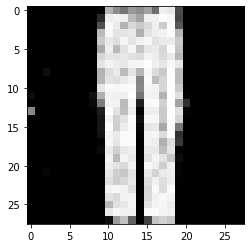

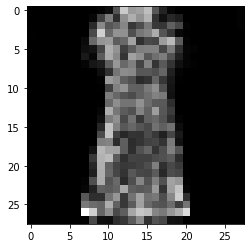

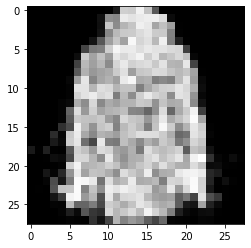

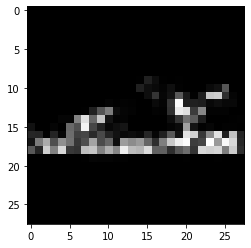

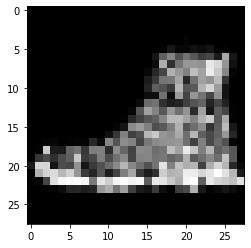

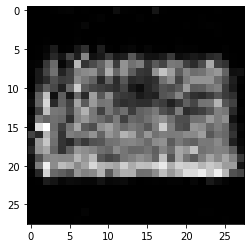

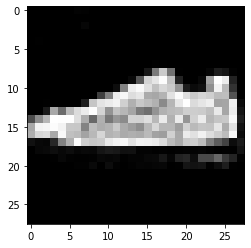

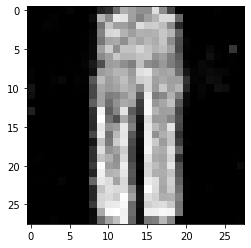

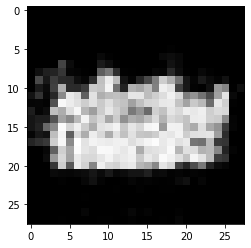

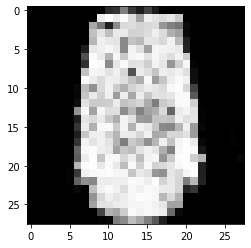

In [0]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.show()